In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

In [4]:
data = pd.read_csv('data.csv', index_col=0)
data

,296,303.3,313.2,323.2
1,256,272,275,264
2,497,503,510,517
3,742,751,765,771
4,986,1000,1016,1030
5,1231,1254,1266,1291
4,993,1000,1013,1029
3,746,746,760,772
2,495,502,510,519
1,263,276,273,264


In [5]:
L = 700E-3
dL = 1E-3
dν = np.array([0,5,3,3,3,3])
dν = np.sqrt(dν**2 + 1**2)
k = 0.02897/8.3144621
dT = 0.1
print(k)

0.0034842903427270418


In [6]:
def chi_fit(X, Y, dY, sigma=1, force_intercept=False):
    """
    Does linear regression y = ax + b using least chi square method
    
    returns a, b, da, db
    """
    
    if len(X) != len(Y):
        raise ValueError("dimensons of X and Y don't match")
    
    L = len(X)
    
    if force_intercept:
        def f(a):
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i])) / dY[i]

            return ret

        result = scipy.optimize.least_squares(f, (1,), ftol=1e-15, xtol=1e-15, gtol=1e-15)
        a, = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_):
            return np.sum(f((a_))**2)

        da = 0
        inc_a = a/10000

        while sigma > chi_2(a+da) - chi_2_min:
            da += inc_a

        return a, 0, da, 0
    else:
        def f(coeffs):
            a, b = coeffs
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i] + b)) / dY[i]

            return ret

        result = scipy.optimize.least_squares(f, (1, 1), ftol=1e-15, xtol=1e-15, gtol=1e-15)
        a, b = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_, b_):
            return np.sum(f((a_, b_))**2)

        da, db = 0, 0
        inc_a = a/10000
        inc_b = b/10000

        while sigma > chi_2(a+da, b) - chi_2_min:
            da += inc_a

        while sigma > chi_2(a, b+db) - chi_2_min:
            db += inc_b

        return a, b, da, db
        

342.1 & 345.0 & 349.4 & 358.9
0.9 & 0.9 & 0.9 & 0.9


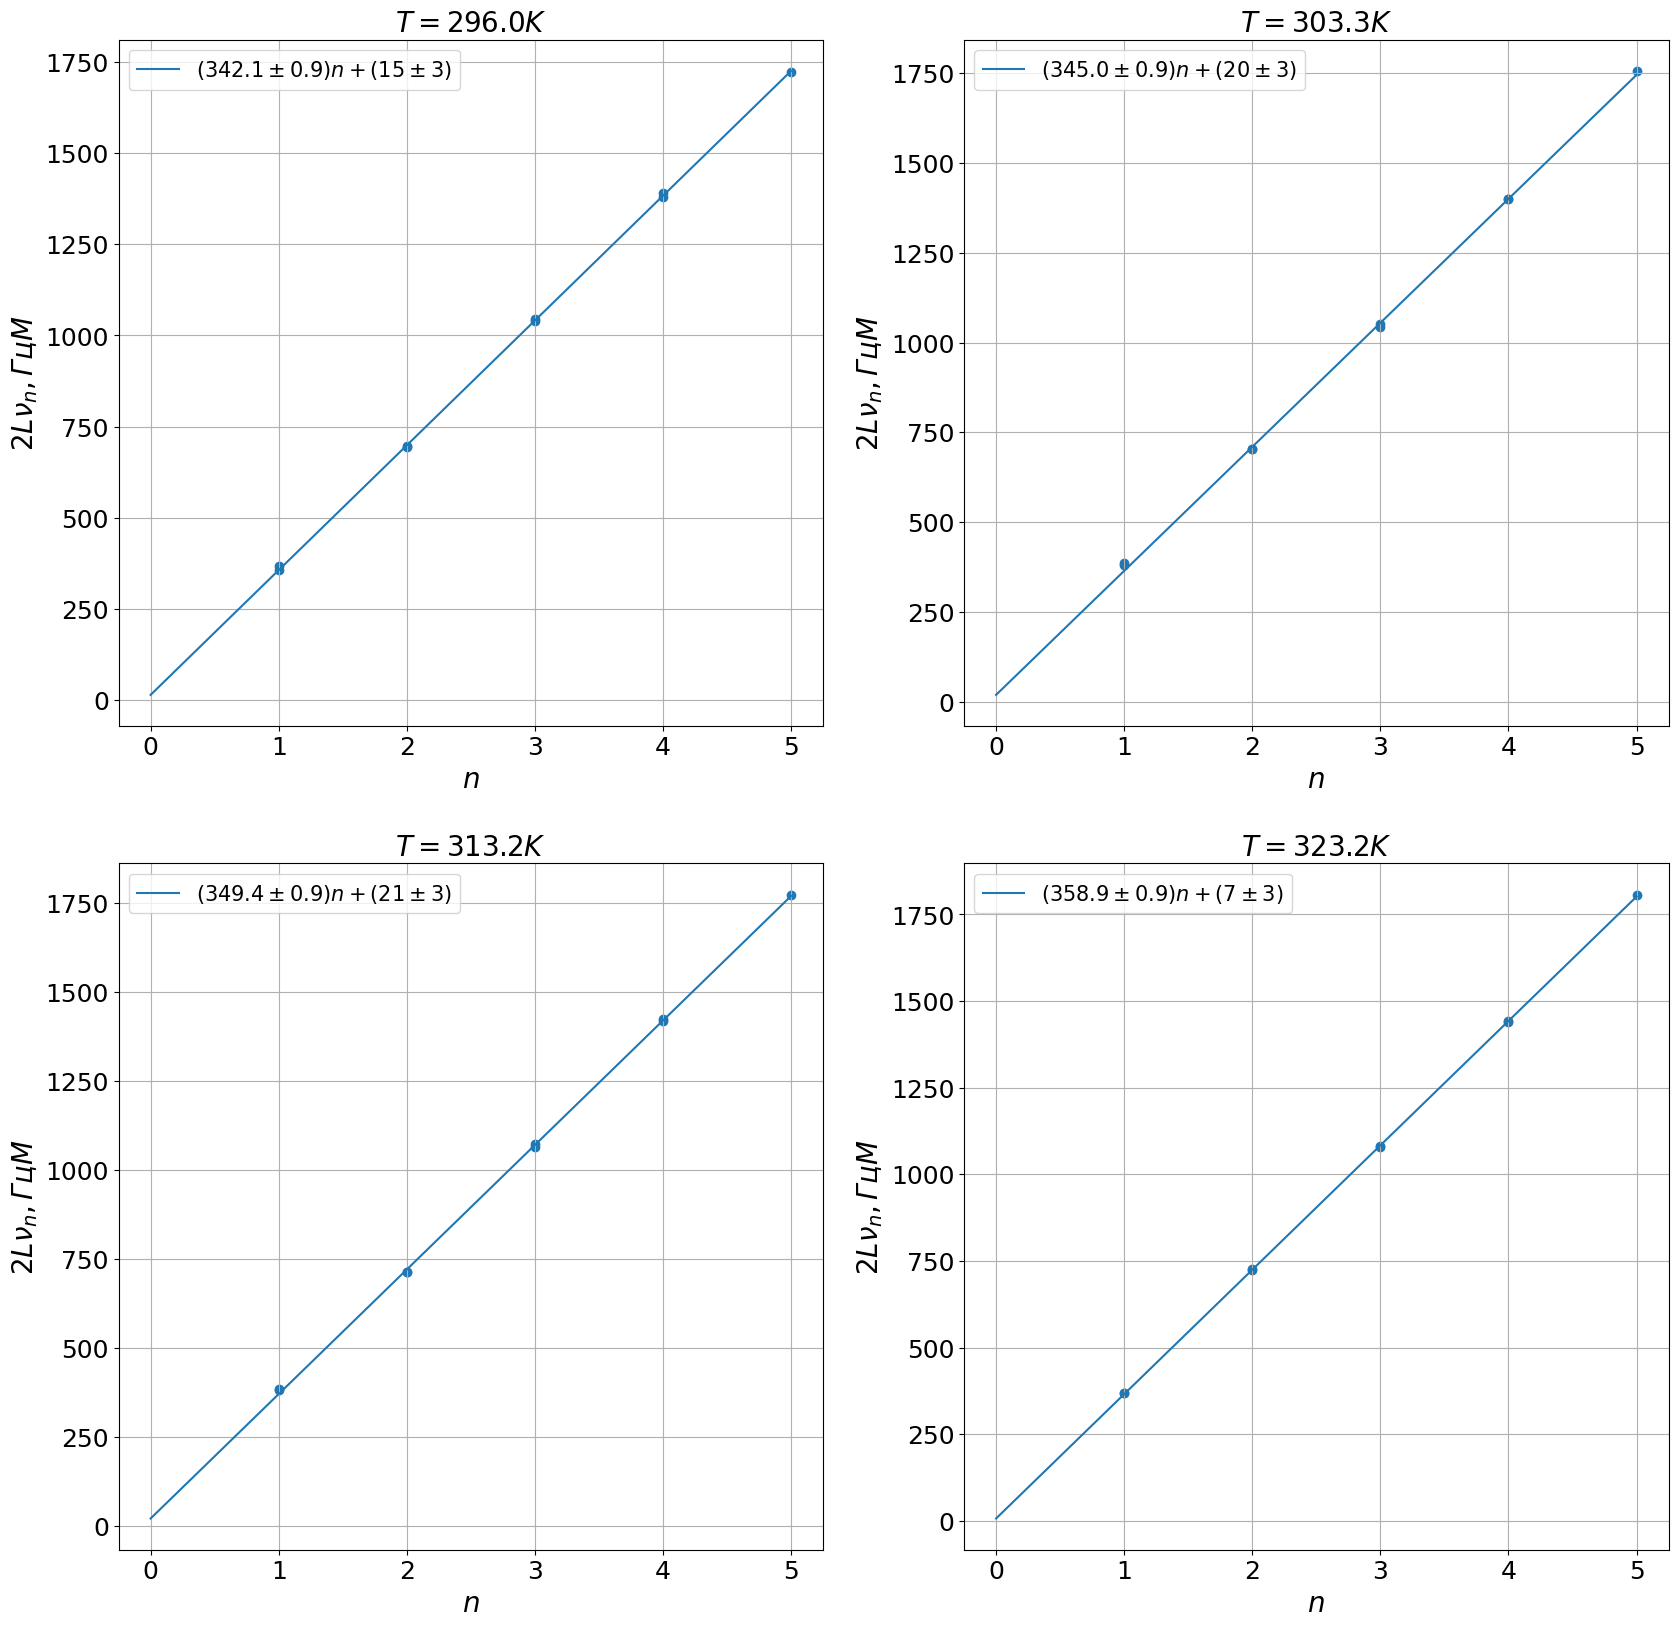

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20), dpi=100)

T = list(data.columns.map(float))
c = []
dc = []

for i in range(4):
    # x,y coordinates of plots
    y = i % 2
    x = i // 2
    
    ax[x, y].grid(True)    
    ax[x, y].set_title(f'$T={T[i]}K$', fontsize=20)
    
    XY = data[data.columns[i]]
    
    X = np.array(data[data.columns[i]].index)
    ν = data[data.columns[i]].to_numpy()
    Y = 2 * L * ν
    # Y = cX + b
    
    dY = Y*np.sqrt((dL/L)**2+(dν[X]/ν)**2)
    
    ax[x, y].scatter(X, Y)
#     ax[x, y].errorbar(X, Y, xerr=0, yerr=dY, linestyle='')
    
    ax[x,y].set_xlabel(r"$n$", fontsize=20)
    ax[x,y].set_ylabel(r"$2L\nu_n, ГцМ$", fontsize=20)
    
    ax[x, y].tick_params(axis='x', labelsize=18)
    ax[x, y].tick_params(axis='y', labelsize=18)
    
    c_, b_, dc_, db_ = chi_fit(X, Y, dY, sigma=3)
    ax[x, y].plot([0, 5], [b_, b_ + 5*c_], label=f'$({c_:.1f}\pm{dc_:.1f})n +({b_:1.0f}\pm{db_:1.0f})$')
    ax[x, y].legend(fontsize=15)
    
    c.append(c_)
    dc.append(dc_)

plt.savefig('../pictures/speed_of_sound_plots.png')

T = np.array(T)
c = np.array(c)
dc = np.array(dc)
print(' & '.join(list(map(str,list(np.round(c,1))))))
print(' & '.join(list(map(str,list(np.round(dc,1))))))

In [11]:
print(' & '.join(list(map(str,list(np.round(k*c*c/T,2))))))

1.38 & 1.37 & 1.36 & 1.39


1.47506103375947 \pm 0.003687652584398676


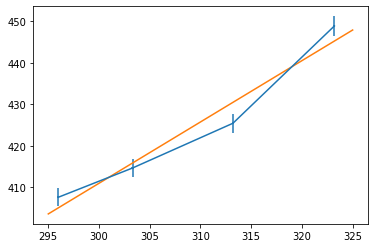

In [12]:
γ, b, dγ, db = chi_fit(T, k*c**2, 2*k*c*dc)
plt.errorbar(T, k*c**2, xerr=dT, yerr=2*k*c*dc)
plt.plot([295, 325], [γ*295 + b, γ*325 + b])
print(f"{γ} \pm {dγ}")

In [13]:
np.mean(k*c*c/T), np.std(k*c*c/T)

(1.3729205414949202, 0.011340211298241767)